In [1]:
import re
import numpy as np
import pandas as pd
import openpyxl

import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import geographiclib
from geographiclib.geodesic import Geodesic
import utm
from shapely.ops import nearest_points

import sys
import os
import requests
from bs4 import BeautifulSoup
from lxml import html
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

import io
import json

pd.set_option('display.max_rows',999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


warnings.filterwarnings("ignore")
#import unicodedata
#import gzip

In [2]:
import plotly.graph_objects as go
import plotly.express as px

In [117]:
import plotly

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

colores

In [115]:
cl = [e for e in sns.color_palette('rocket',20)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2]

idx

In [5]:
idx = pd.IndexSlice

Bases

In [6]:
direc = 'c:\\Users\\Franco\\Python\\CAF\\files\\clean\\'
files = os.listdir(direc)

In [7]:
files

['accesom.xlsx',
 'accesom_2.xlsx',
 'cwpops.xlsx',
 'dbiz.xlsx',
 'dbizi.xlsx',
 'distances.xlsx',
 'es.xlsx',
 'geom_air.xlsx',
 'laboral.xlsx',
 'latlongs.xlsx',
 'metro_areas.xlsx',
 'mlab.xlsx',
 'mlabi.xlsx',
 'properati.xlsx',
 'properati_i.xlsx',
 'sectores.xlsx']

In [8]:
sectores = pd.read_excel(direc+'sectores.xlsx',index_col=[0,1])
laboral = pd.read_excel(direc+'laboral.xlsx',index_col=[0,1])
acceso = pd.read_excel(direc+'accesom_2.xlsx',index_col=[0,1])
cw = pd.read_excel(direc+'cwpops.xlsx',index_col=[0,1])
latlongs = pd.read_excel(direc+'latlongs.xlsx',index_col=[0,1])

In [9]:
sectores = sectores.join(sectores.loc[:,['Agro','Baja Tec','Resto Ind']].groupby('Country').mean(),rsuffix=' promedio nacional')

In [10]:
[sectores['Ratio Agro'],sectores['Ratio Baja Tec'],sectores['Ratio Resto Ind']] = [sectores['Agro']/sectores['Agro promedio nacional'],sectores['Baja Tec']/sectores['Baja Tec promedio nacional'],sectores['Resto Ind']/sectores['Resto Ind promedio nacional']]

In [11]:
cw['pops'] = cw['pops']/1000000

### Ciudades de referencia

In [12]:
ref = ['Manizales','Pereira','Medellin','Villavicencio','Monteria','Ibague','Gran Resistencia','Morelia','Aracaju']
ref_prom = ref + ['Promedio Colombia','Promedio Latam']

In [13]:
comp = cw.loc[idx[:,ref],'pops'].to_frame().join(laboral.loc[:,['Salario Horario (PPP 2011)','Tasa de Desempleo Total','% población con secundario completo Total']]).join(acceso.loc[:,['cutoff_0','cutoff_9']]).join(sectores.loc[:,['Ratio Agro','Ratio Baja Tec','Ratio Resto Ind']])

In [14]:
comp = comp.rename(columns={'pops':'Población estimada (millones)','cutoff_0':'Masa Salarial como proporción del país','cutoff_9':'Proporción de la masa salarial del país a la que se accede en < 9 hs'})

In [59]:
print(BeautifulSoup(comp.to_html(), 'html.parser'))

<table border="1" class="dataframe">
<thead>
<tr style="text-align: right;">
<th></th>
<th></th>
<th>Población estimada (millones)</th>
<th>Salario Horario (PPP 2011)</th>
<th>Tasa de Desempleo Total</th>
<th>% población con secundario completo Total</th>
<th>Masa Salarial como proporción del país</th>
<th>Proporción de la masa salarial del país a la que se accede en &lt; 9 hs</th>
<th>Ratio Agro</th>
<th>Ratio Baja Tec</th>
<th>Ratio Resto Ind</th>
</tr>
<tr>
<th>Country</th>
<th>City</th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<th>Argentina</th>
<th>Gran Resistencia</th>
<td>0.29</td>
<td>3.77</td>
<td>1.61</td>
<td>43.13</td>
<td>0.01</td>
<td>0.12</td>
<td>0.21</td>
<td>0.57</td>
<td>0.34</td>
</tr>
<tr>
<th>Brasil</th>
<th>Aracaju</th>
<td>0.62</td>
<td>4.43</td>
<td>16.10</td>
<td>36.91</td>
<td>0.01</td>
<td>0.10</td>
<td>1.32</td>
<td>0.74</td>
<td>0.57</td>
</tr>
<tr>
<th rowspan="6" valign="top">Co

Gráfico de Salarios y poblaciones

In [61]:
plot1 = comp.iloc[:,:2].droplevel(0)

In [96]:
proms = pd.concat([cw.loc[:,['pops']].mean().to_frame().T.append(cw.loc['Colombia',['pops']].mean().to_frame().T),pd.Series(laboral.iloc[:,0].mean()).append(pd.Series(laboral.loc['Colombia','Salario Horario (PPP 2011)'].mean())).to_frame()],axis=1).rename(columns={'pops':'Población estimada (millones)',0:'Salario Horario (PPP 2011)'})
proms['City'] = ['Poromedio Latam','Promedio Colombia']
proms = proms.set_index('City')

In [100]:
plot1 = plot1.append(proms)

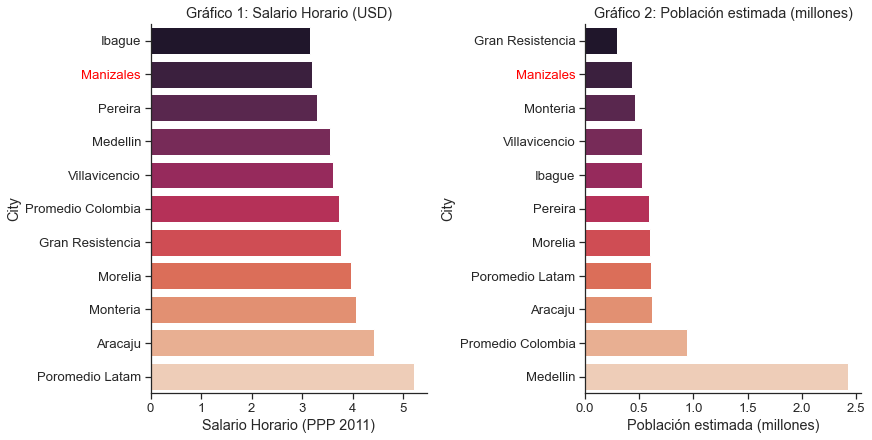

In [163]:
f, axes = plt.subplots(1, 2,figsize=(12,6) ,constrained_layout=True)

sns.barplot(x='Salario Horario (PPP 2011)', y=plot1.sort_values('Salario Horario (PPP 2011)').index, data=plot1.sort_values('Salario Horario (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 1: Salario Horario (USD)')
sns.barplot(x='Población estimada (millones)', y=plot1.sort_values('Población estimada (millones)').index, data=plot1.sort_values('Población estimada (millones)'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 2: Población estimada (millones)')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()

plt.ticklabel_format(style='plain', axis='x')
#plt.tight_layout()
#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0].get_yticklabels()[1].set_color('red')
axes[1].get_yticklabels()[1].set_color('red')

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/wyp.png",bbox_inches='tight')

Scatter

In [122]:
sectores['Principal Sector'] = sectores.iloc[:,-3:].idxmax(axis='columns')

wage_comp = sectores.loc[idx['Colombia',:],['Salario Estimado','Principal Sector']].join(laboral.iloc[:,0])
wage_comp = wage_comp.reset_index()

In [120]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y']+.05, str(point['val']))

NameError: name 'wage_comp' is not defined

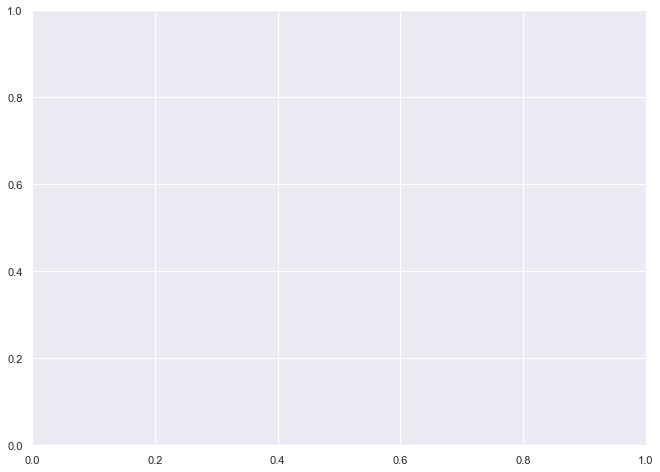

In [874]:
fig, ax = plt.subplots(figsize=(11,8))

sns.scatterplot(data=wage_comp, x="Salario Estimado", y="Salario Horario (PPP 2011)" , ax=ax  , hue='Principal Sector', s=120, palette='rocket').set_title('Gráfico 3: Salario Esperado vs Salario Observado. Se colorea según principal sector entre Agro, Ind Baja y Resto Ind.')

ax.plot([0, 1], [0, 1], transform=ax.transAxes , color='Black' , linestyle='--') 
#plt.legend(bbox_to_anchor=(0.25,0.95), loc="upper right")
#ax.get_legend().remove()

plt.tight_layout()
sns.set(font_scale=1.0)
sns.set_style("ticks")
sns.despine()

label_point(wage_comp["Salario Estimado"] , wage_comp["Salario Horario (PPP 2011)"] , wage_comp['City'] , plt.gca())

plt.xlim(3,)
plt.ylim(3,)

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/scat_esperado_observado_2.png",bbox_inches='tight')

Sectores

In [151]:
w_manizales = sectores.loc[idx[:,'Manizales'],['share_emp_s1', 'share_emp_s2', 'share_emp_s3', 'share_emp_s4',
       'share_emp_s5', 'share_emp_s6', 'share_emp_s7', 'share_emp_s8',
       'share_emp_s9', 'share_emp_s10','Agro', 'Baja Tec', 'Resto Ind',
       'Construcción', 'Comercio', 'Infraestructura', 'Bancos', 'Adm publi',
       'Educ y Salud', 'Serv doméstic']].stack().to_frame().reset_index().rename(columns={'level_2':'Actividad',0:'Proporción'})

In [152]:
w_manizales['Grupo'] = ['Empleo']*10 + ['Masa Salarial']*10

In [153]:
w_manizales = w_manizales.drop(columns=['Country','City'])

In [154]:
w_manizales = w_manizales.replace({'Actividad':dict(zip(w_manizales['Actividad'][:10],w_manizales['Actividad'][10:]))})

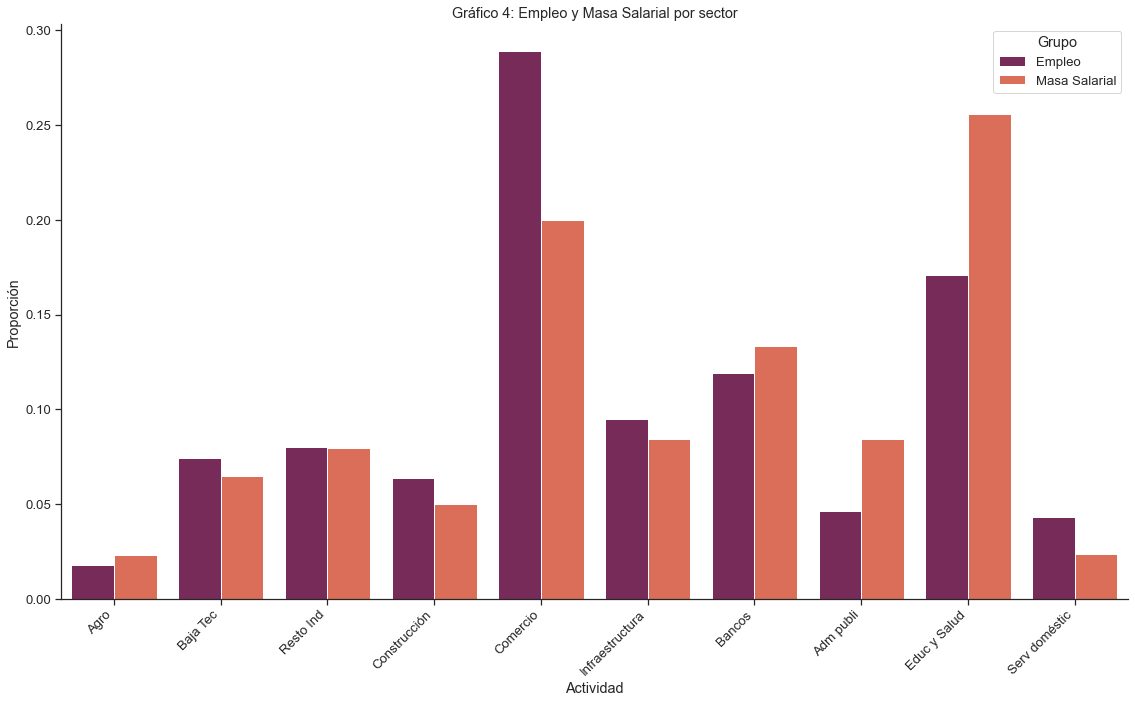

In [228]:
fig, ax = plt.subplots(figsize=(16,10))
g = sns.barplot(x='Actividad', y='Proporción', hue='Grupo', data=w_manizales , palette='rocket' , linewidth=1)

g.set_title('Gráfico 4: Empleo y Masa Salarial por sector')
g.set_xticklabels(w_manizales['Actividad'].unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/wm_sectores.png",bbox_inches='tight')
plt.tight_layout()

Distribución de Actividades

In [219]:
dist = laboral[laboral.columns[19:24]].droplevel(0)

In [220]:
mean = dist.mean().to_frame().T
mean['City'] = 'Promedio Latam'
mean = mean.set_index('City')

In [221]:
dist_plot = dist.loc[ref,:].append(dist.loc[('Colombia 2018 (total ciudades)')].to_frame().T.reset_index().rename(columns={'index':'City'}).replace({'City':{'Colombia 2018 (total ciudades)':'Promedio Colombia'}}).set_index('City').append(mean))

In [222]:
dist_plot = dist_plot.sort_values('Distribución de ocupados según relación laboral Asalariado  (total)')

In [223]:
dist_plot = dist_plot.drop(columns='Distribución de ocupados según relación laboral Asalariado  (total)')

In [224]:
dist_plot = dist_plot.rename(columns=dict(zip(dist_plot.columns.tolist(),['Asalariado (público)','Asalariado (privado)','Patrón o Cuentapropista','Sin salario'])))

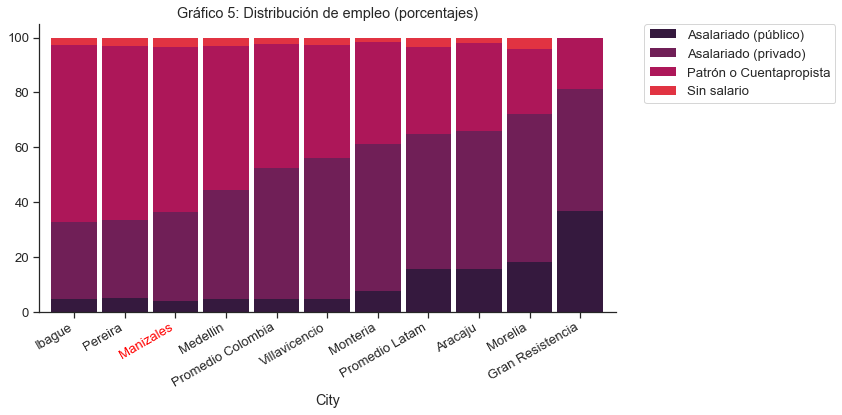

In [227]:
sns.set_palette('rocket')

fig, ax = plt.subplots(1, 1,figsize=(12,6))

dist_plot.plot(kind='bar', stacked=True , ax=ax , color=sns.color_palette() , width=0.9 , linewidth=0.001).set_title('Gráfico 5: Distribución de empleo (porcentajes)')

fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.gca().get_xticklabels()[2].set_color('red')

plt.tight_layout()
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/empleo_dist.png",bbox_inches='tight')

## Disponibilidad de indicadores

### Con Ext

In [44]:
mlab = pd.read_excel(direc+'mlabi.xlsx',index_col=[0,1])

Medias

In [45]:
mlab_medias = mlab.mean().to_frame().T.append(mlab.loc['Colombia'].mean().to_frame().T)

In [46]:
mlab_medias['City'] = ['Promedio Latam','Promedio Colombia']

In [47]:
mlab_medias = mlab_medias.set_index(['City'])

In [51]:
mlab_plot = mlab.drop(columns='City Original').droplevel(0).append(mlab_medias).loc[ref_prom,'Median Download'].to_frame()

Plot

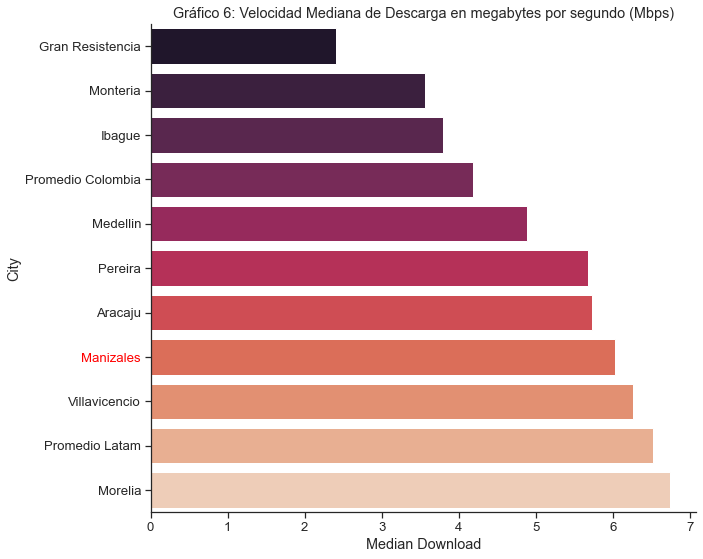

In [73]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Median Download', y=mlab_plot.sort_values('Median Download').index, data=mlab_plot.sort_values('Median Download') , palette='rocket' , orient='h' ).set_title('Gráfico 6: Velocidad Mediana de Descarga en megabytes por segundo (Mbps)')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.gca().get_yticklabels()[7].set_color('red')

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/descarga.png",bbox_inches='tight')
plt.tight_layout()

### Acceso a mercados

tabla

In [118]:
tabla = distances.loc[(distances['City A']=='Manizales')&(distances['duration_traffic']<5),['Country','City A','City B','Distance','duration_traffic']].rename(columns={'City B':'City'}).set_index(['Country','City']).join(merge.iloc[:,np.r_[0,1,2,3,-3,-2,-1]],how='left')

In [119]:
tabla = tabla.rename(columns={'Distance':'Distancia','duration_traffic':'horas de viaje en tráfico'}).drop(columns=['City A']).sort_values('horas de viaje en tráfico')

In [120]:
tabla = tabla.droplevel(0).reset_index().rename(columns={'City':'Ciudad'}).set_index('Ciudad')

In [127]:
#r'C:\Users\Franco\Python\CAF\Entregables\Informes\manizales 2\informe\images\tabla6.html'
BeautifulSoup(tabla.to_html(justify='left'), 'html.parser')#.prettify()

#<p style="text-align: center;">Tabla 6: Ciudades Cercanas</p>

<table border="1" class="dataframe">
<thead>
<tr style="text-align: left;">
<th></th>
<th>Distancia</th>
<th>horas de viaje en tráfico</th>
<th>Población estimada (millones)</th>
<th>Salario Horario (PPP 2011)</th>
<th>Tasa de Desempleo</th>
<th>% población con secundario completo</th>
<th>Ratio Agro</th>
<th>Ratio Ind Baja</th>
<th>Ratio Resto Ind</th>
</tr>
<tr>
<th>Ciudad</th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<th>Pereira</th>
<td>52.4 km</td>
<td>1.083</td>
<td>0.591</td>
<td>3.289</td>
<td>7.636</td>
<td>37.533</td>
<td>1.016</td>
<td>1.449</td>
<td>1.163</td>
</tr>
<tr>
<th>Cartago</th>
<td>79.8 km</td>
<td>1.667</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
</tr>
<tr>
<th>Armenia</th>
<td>97.6 km</td>
<td>2.000</td>
<td>2.960</td>
<td>3.393</td>
<td>7.870</td>
<td>36.443</td>
<td>1.363</td>
<td>0.724</td>
<td>0.826</td>
</tr>
<tr>
<th>Tulua</th>
<

Grafico

In [56]:
acceso = acceso.drop(columns='index1')

In [57]:
medias = acceso.loc['Colombia'].mean().to_frame().T.append(acceso.mean().to_frame().T)

In [58]:
medias['City'] = ['Promedio Colombia','Promedio Latam']

In [59]:
medias = medias.set_index(['City'])

In [62]:
acceso_plot = acceso.droplevel(0).append(medias).loc[ref_prom]

In [63]:
mydict = dict(zip(['cutoff_{}'.format(e) for e in range(10)],[e for e in range(10)]))

In [68]:
acceso_plot = acceso_plot.sort_values('cutoff_9').stack().reset_index().rename(columns={'level_1':'horas',0:'% de masa salarial'}).replace(mydict).set_index('City')

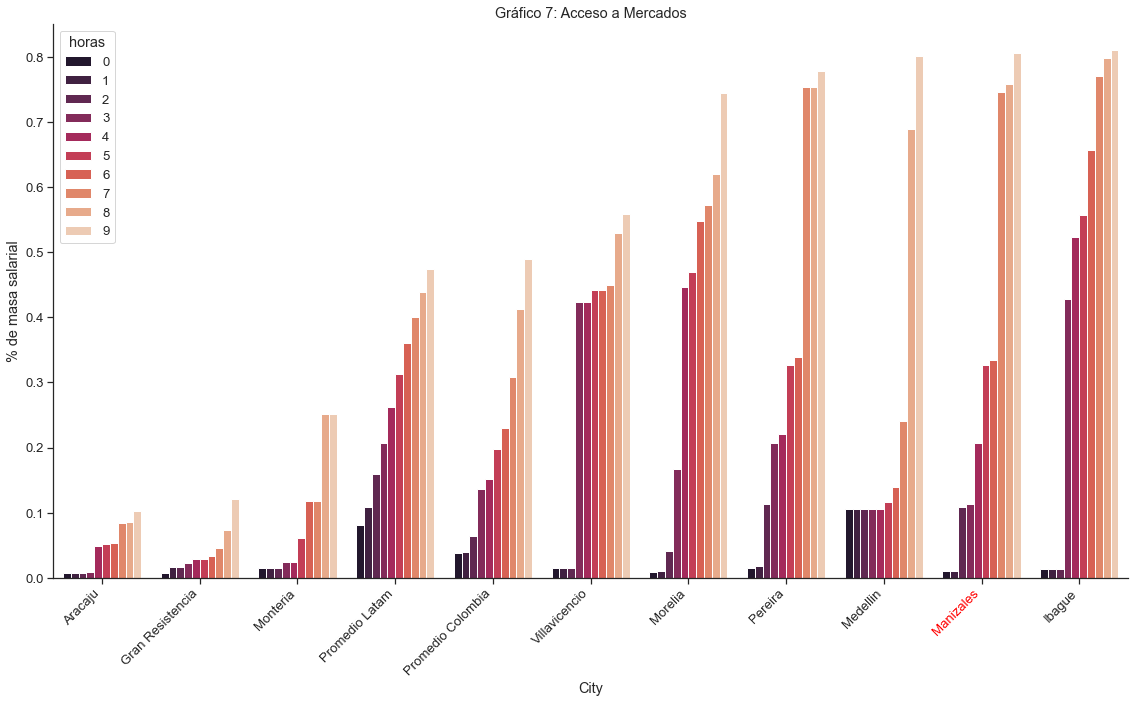

In [74]:
fig, ax = plt.subplots(figsize=(16,10)) #,constrained_layout=True
g = sns.barplot(x=acceso_plot.index, y="% de masa salarial", hue='horas', data=acceso_plot , palette='rocket' , linewidth=1)

g.set_title('Gráfico 7: Acceso a Mercados')
g.set_xticklabels(acceso_plot.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.gca().get_xticklabels()[9].set_color('red')

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/acceso.png",bbox_inches='tight')
plt.tight_layout()

### Conectividad Interna

mlab

Biggest obstacle transport

In [641]:
es_latam = es[es['Economy'].isin(['Argentina','Brazil','Mexico','Colombia','Ecuador','Peru','Uruguay','Paraguay','Panama','Costa Rica','Chile'])]

In [644]:
es_city = es_latam[es_latam['Subgroup']=='Location']

In [649]:
es_city = es_city.rename(columns={'Economy':'Country','Subgroup Level':'City'}).set_index(['Country','City'])

In [664]:
es_city['Year'] = es_city['Year'].astype('int')

In [672]:
keep = es_city.groupby('Country')['Year'].max().reset_index()

In [701]:
es_city = es_city.reset_index().loc[:,['Country','City','Year','Percent of firms choosing transportation as their biggest obstacle']].merge(keep,how='inner',on=['Country','Year']).drop(index=10).reset_index()

In [705]:
es_city = es_city.reset_index().drop(columns='index')

In [706]:
es_city[es_city.columns[-1]] = es_city[es_city.columns[-1]].astype('float')

In [712]:
media = es_city.mean().to_frame().T

In [719]:
media['Country'] = ['promedio Latam']

In [723]:
media.Year = media.Year.astype('int')

In [726]:
media[media.columns[-2]] = media[media.columns[-2]].astype('float')

In [728]:
plot = es_city.groupby(['Country']).mean().append(media.set_index('Country'))

In [729]:
plot

,Year,Percent of firms choosing transportation as their biggest obstacle
Country,,
Argentina,2017,1.9
Brazil,2009,0.9
Chile,2010,7.1
Colombia,2017,1.4
Costa Rica,2010,1.4
Ecuador,2017,0.7
Mexico,2010,1.9
Panama,2010,0.3
Paraguay,2017,5.1


### Trabajo y Conocimiento

In [894]:
es_latam.loc[(es_latam['Economy']=='Colombia')&(es_latam['Year']==2017)]

,Economy,Year,Subgroup,Top Subgroup Level,Subgroup Level,Average/SE/N,Percent of firms choosing access to finance as their biggest obstacle,Percent of firms choosing access to land as their biggest obstacle,Percent of firms choosing business licensing and permits as their biggest obstacle,Percent of firms choosing corruption as their biggest obstacle,...,"Percent of firms choosing crime, theft and disorder as their biggest obstacle",Percent of firms choosing customs and trade regulations as their biggest obstacle,Percent of firms choosing electricity as their biggest obstacle,Percent of firms choosing inadequately educated workforce as their biggest obstacle,Percent of firms choosing labor regulations as their biggest obstacle,Percent of firms choosing political instability as their biggest obstacle,Percent of firms choosing practices of the informal sector as their biggest obstacle,Percent of firms choosing tax administration as their biggest obstacle,Percent of firms choosing tax rates as their biggest obstacle,Percent of firms choosing transportation as their biggest obstacle
1180,Colombia,"2,017.0",NaN,NaN,NaN,Average,7.5,0.3,4.5,12.7,...,3,4.9,2.2,7.7,3.7,6.3,21.2,3.4,19.5,1.9
1181,Colombia,"2,017.0",Sector,Manufacturing,All,Average,4.9,0.1,3.7,12.3,...,3,4.3,5.3,4.2,4.9,10.4,29.3,1.9,14.5,1.2
1182,Colombia,"2,017.0",Sector,Manufacturing,Food,Average,6.3,0.9,7.1,6.9,...,11.9,0.1,4.2,3.2,4.6,4.6,22.3,6.3,17.8,3
1183,Colombia,"2,017.0",Sector,Manufacturing,Textiles & Garments,Average,4.5,0,0.3,9.9,...,2.1,1.9,3.7,1.1,16.8,4.1,25.9,2.5,25.8,1.3
1184,Colombia,"2,017.0",Sector,Manufacturing,Other Manufacturing,Average,4.8,0,3.8,13.6,...,1.7,5.5,5.8,5,2.6,12.5,31,1.1,11.9,0.9
1185,Colombia,"2,017.0",Sector,Services,All,Average,8.5,0.4,4.8,12.9,...,3.1,5.2,1,9,3.3,4.6,18,4,21.4,2.1
1186,Colombia,"2,017.0",Sector,Services,Retail,Average,11.5,0.1,0.9,19,...,1.6,0.1,0.1,2.7,0.2,2,19.7,7.1,30.6,3.6
1187,Colombia,"2,017.0",Sector,Services,Other Services,Average,7.7,0.4,5.9,11.2,...,3.4,6.5,1.3,10.7,4.1,5.3,17.6,3.2,19,1.7
1188,Colombia,"2,017.0",Size,NaN,Small (5-19),Average,8.2,0.5,3.4,10.9,...,1.8,7.6,2.2,8,3.4,4,24.3,3.4,20,1.8
1189,Colombia,"2,017.0",Size,NaN,Medium (20-99),Average,7.7,0,5.4,15.1,...,4.3,0.7,2.8,7.2,4.8,6.2,17.3,3.8,20.9,2.1


In [901]:
k = es_latam.groupby('Economy')['Year'].max().reset_index()

In [906]:
avg_con = es_latam.merge(k,how='inner',on=['Economy','Year']).groupby('Economy').head(1)

In [915]:
avg_con[avg_con.columns[6:]] = avg_con[avg_con.columns[6:]].apply(pd.to_numeric, downcast='float')

In [927]:
avg_con.loc[:,['Economy','Year','Percent of firms choosing inadequately educated workforce as their biggest obstacle']].mean()

Year                                                                                  2,013.7
Percent of firms choosing inadequately educated workforce as their biggest obstacle      10.2
dtype: float64

In [931]:
es_latam.merge(k,how='inner',on=['Economy','Year']).loc[:,['Economy','Subgroup Level','Percent of firms choosing inadequately educated workforce as their biggest obstacle']]

,Economy,Subgroup Level,Percent of firms choosing inadequately educated workforce as their biggest obstacle
0,Argentina,NaN,6.3
1,Argentina,All,6.4
2,Argentina,Food,6.2
3,Argentina,Textiles & Garments,6.4
4,Argentina,Other Manufacturing,6.5
5,Argentina,All,6.1
6,Argentina,Retail,9.3
7,Argentina,Other Services,4.7
8,Argentina,Small (5-19),6.7
9,Argentina,Medium (20-99),5.1


Laboral

In [87]:
medias = laboral.reset_index().loc[laboral.reset_index()['City'].str.contains('(total ciudades)|(Total Ciudades)')].iloc[4,:].to_frame().T.append(laboral.reset_index().loc[laboral.reset_index()['City'].str.contains('(total ciudades)|(Total Ciudades)')].mean().to_frame().T)

In [90]:
medias = medias.drop(columns='Country')
medias['City'] = ['Promedio Colombia','Promedio Latam']

In [95]:
laboral_ref = laboral.droplevel(0).append(medias.set_index('City')).loc[ref_prom,:]

Act

In [141]:
act = laboral_ref[laboral_ref.columns[4:7]]
act['dif'] = act['Tasa de Actividad Hombres'] - act['Tasa de Actividad Mujeres ']
act = act.sort_values('Tasa de Actividad Total')

In [142]:
act['Tasa de Actividad (total)'] = act['Tasa de Actividad Total'] * (-1)

In [148]:
act = act.astype('float')

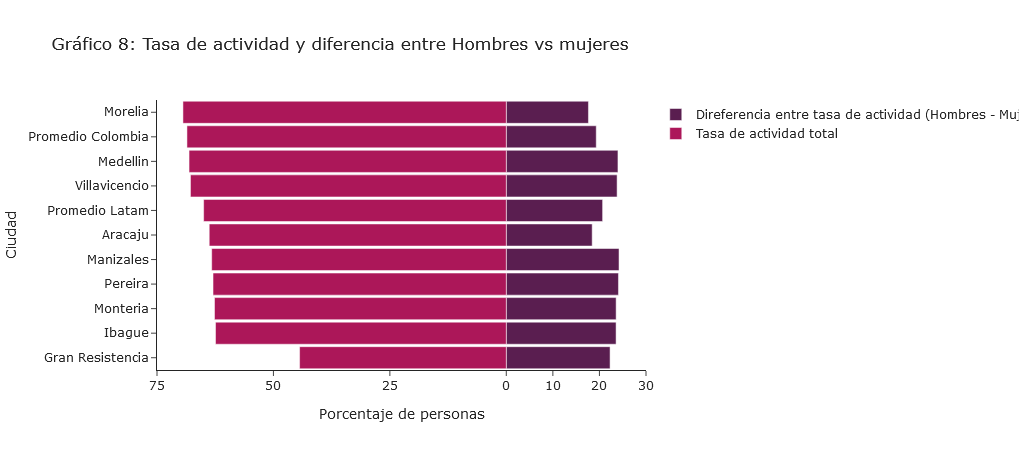

In [762]:
layout = go.Layout(yaxis=go.layout.YAxis(title='Ciudad'),
                   xaxis=go.layout.XAxis(
                       range=[-75, 30],
                       tickvals=[-75, -50, -25, 0, 10, 20, 30],
                       ticktext=[75, 50, 25, 0, 10, 20, 30],
                       title='Porcentaje de personas'),
                    barmode='overlay',
                    bargap=0.1,
                    template="simple_white",
                   title='Gráfico 8: Tasa de actividad y diferencia entre Hombres vs mujeres'
                  )

data = [go.Bar(y=act.index,
               x=act['dif'],
               orientation='h',
               name='Direferencia entre tasa de actividad (Hombres - Mujeres)',
               text=np.round(act['dif'].to_numpy(),2),
               hoverinfo='text',
               marker=dict(color=colors[4]),
                    #hoverlabel=dict(hover_data={act['dif']:':.2f'})
               ),
        go.Bar(y=act.index,
               x=act['Tasa de Actividad (total)'],
               orientation='h',
               name='Tasa de actividad total',
               text= np.round(act['Tasa de Actividad (total)'].to_numpy() * -1,2),
               hoverinfo='text',
               marker=dict(color=colors[8])
               )]

plotly.offline.iplot(dict(data=data, layout=layout)) 
plotly.io.write_html(fig=dict(data=data, layout=layout),file="informe/images/actividad.html",full_html=False,include_plotlyjs='cdn')

Info y desempleo

In [159]:
des = pd.concat([laboral_ref[laboral_ref.columns[1]],laboral_ref[laboral_ref.columns[7]]],axis=1)

In [162]:
des = des.astype('float')

In [164]:
des = des.sort_values('Tasa de Desempleo Total')

In [166]:
des['Tasa de Desempleo (Total)'] = des['Tasa de Desempleo Total'] * (-1)

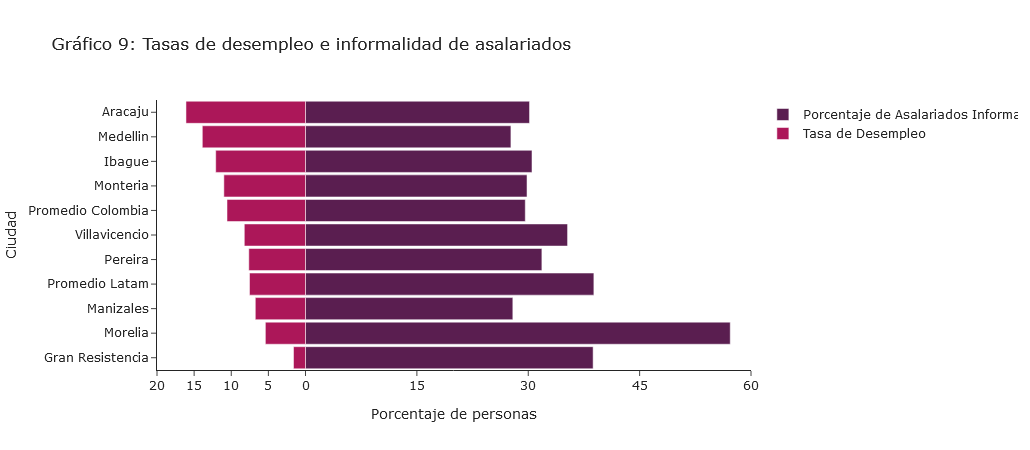

In [168]:
layout = go.Layout(yaxis=go.layout.YAxis(title='Ciudad'),
                   xaxis=go.layout.XAxis(
                       range=[-20, 60],
                       tickvals=[-20, -15, -10, -5, 0, 15, 30, 45, 60],
                       ticktext=[20, 15, 10, 5, 0, 15, 30, 45, 60],
                       title='Porcentaje de personas'),
                    barmode='overlay',
                    bargap=0.1,
                    template="simple_white",
                   title='Gráfico 9: Tasas de desempleo e informalidad de asalariados'
                  )

data = [go.Bar(y=des.index,
               x=des['% Asalariados Informales Total'],
               orientation='h',
               name='Porcentaje de Asalariados Informales',
               text=np.round(des['% Asalariados Informales Total'].to_numpy(),2),
               hoverinfo='text',
               marker=dict(color=colors[4]),
                    #hoverlabel=dict(hover_data={act['dif']:':.2f'})
               ),
        go.Bar(y=des.index,
               x=des['Tasa de Desempleo (Total)'],
               orientation='h',
               name='Tasa de Desempleo',
               text= np.round(des['Tasa de Desempleo (Total)'].to_numpy() * -1,2),
               hoverinfo='text',
               marker=dict(color=colors[8])
               )]

plotly.offline.iplot(dict(data=data, layout=layout)) 
plotly.io.write_html(fig=dict(data=data, layout=layout),file="informe/images/desempleo.html",full_html=False,include_plotlyjs='cdn')

desempleo etario

In [174]:
deset = laboral_ref.loc[:,['Tasa de Desempleo 15-24','Tasa de Desempleo 25-54','Tasa de Desempleo 55 (+)']].sort_values('Tasa de Desempleo 25-54')

In [177]:
des_plot = deset.stack().to_frame().reset_index().rename(columns={'level_1':'Rango Etario',0:'Porcentaje'}).set_index(['City'])#.sort_values(['City','Rango Etario'])

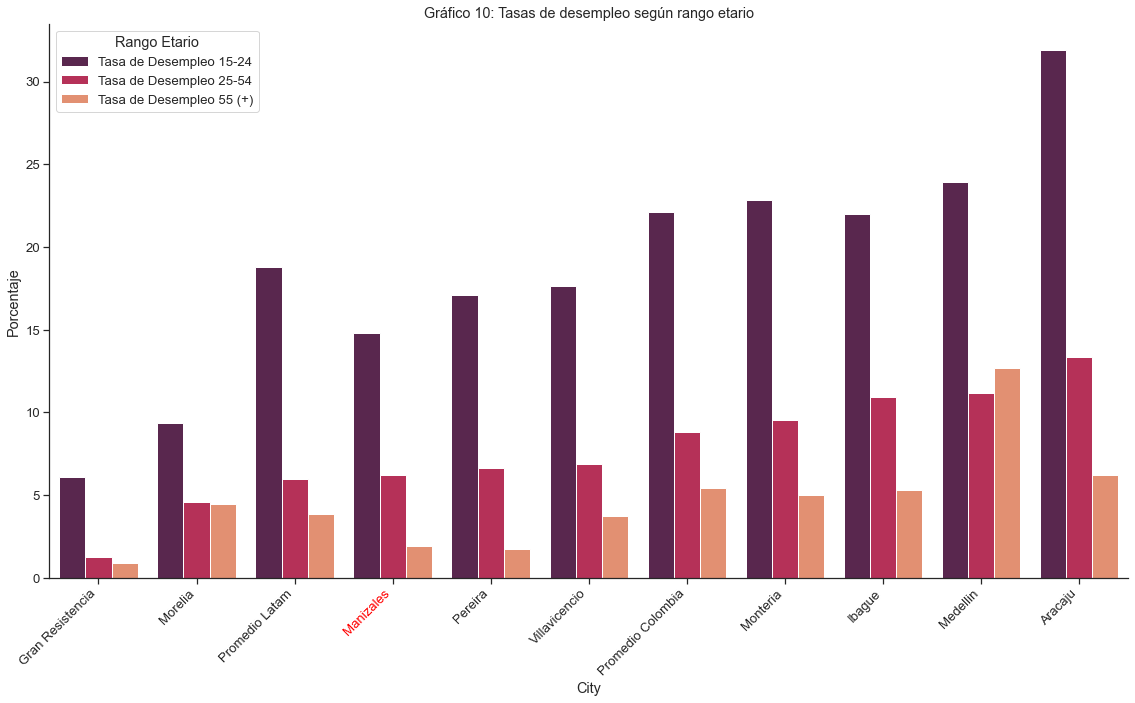

In [179]:
fig, ax = plt.subplots(figsize=(16,10))
g = sns.barplot(x=des_plot.index, y='Porcentaje', hue='Rango Etario', data=des_plot , palette='rocket' , linewidth=1)

g.set_title('Gráfico 10: Tasas de desempleo según rango etario')
g.set_xticklabels(des_plot.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()

#plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.gca().get_xticklabels()[3].set_color('red')
plt.tight_layout()

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/des_etario.png",bbox_inches='tight')

Educación

In [184]:
edu = laboral_ref.loc[:,['% población con secundario completo Total','% población con superior completo Total']]

In [185]:
edu = edu.astype('float')

In [186]:
edu = edu.sort_values('% población con secundario completo Total')

In [187]:
edu['% población con secundario completo (total)'] = edu['% población con secundario completo Total'] * (-1)

In [188]:
edu

,% población con secundario completo Total,% población con superior completo Total,% población con secundario completo (total)
City,,,
Morelia,34.89,16.56,-34.89
Aracaju,36.91,10.54,-36.91
Pereira,37.53,7.21,-37.53
Ibague,38.10,7.49,-38.10
Manizales,39.31,7.78,-39.31
Medellin,39.63,7.86,-39.63
Villavicencio,40.84,8.78,-40.84
Promedio Latam,41.33,12.49,-41.33
Monteria,42.43,9.88,-42.43


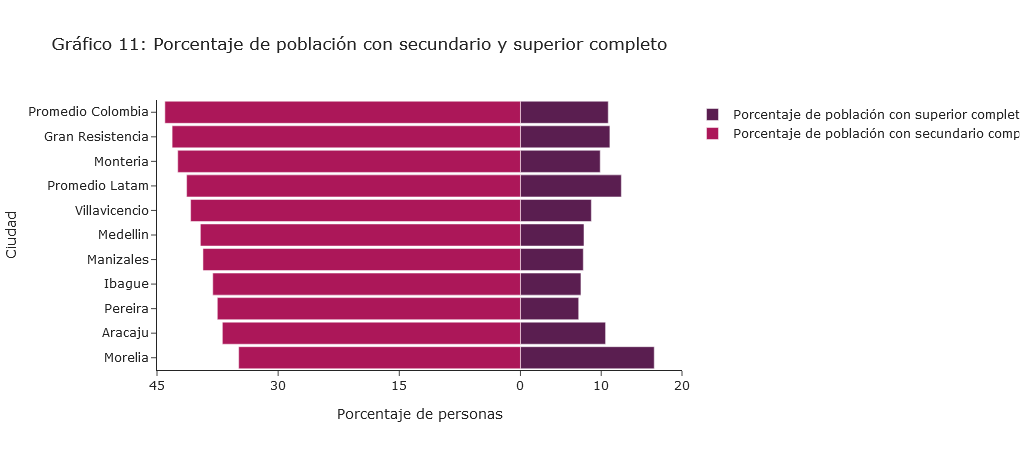

In [191]:
layout = go.Layout(yaxis=go.layout.YAxis(title='Ciudad'),
                   xaxis=go.layout.XAxis(
                       range=[-45, 20],
                       tickvals=[-45, -30, -15, 0, 10, 20],
                       ticktext=[45, 30, 15, 0, 10, 20],
                       title='Porcentaje de personas'),
                    barmode='overlay',
                    bargap=0.1,
                    template="simple_white",
                   title='Gráfico 11: Porcentaje de población con secundario y superior completo'
                  )

data = [go.Bar(y=edu.index,
               x=edu['% población con superior completo Total'],
               orientation='h',
               name='Porcentaje de población con superior completo',
               text=np.round(edu['% población con superior completo Total'].to_numpy(),2),
               hoverinfo='text',
               marker=dict(color=colors[4]),
                    #hoverlabel=dict(hover_data={act['dif']:':.2f'})
               ),
        go.Bar(y=edu.index,
               x=edu['% población con secundario completo (total)'],
               orientation='h',
               name='Porcentaje de población con secundario completo',
               text= np.round(edu['% población con secundario completo (total)'].to_numpy() * -1,2),
               hoverinfo='text',
               marker=dict(color=colors[8])
               )]

plotly.offline.iplot(dict(data=data, layout=layout)) 
plotly.io.write_html(fig=dict(data=data, layout=layout),file="informe/images/edu1.html",full_html=False,include_plotlyjs='cdn')

In [210]:
edu2 = laboral_ref.loc[:,['% población con superior completo 25 a 35 años de edad','% población con secundario completo % población 18-25 años  que se encuentra estudiando nivel superior o terciario']].sort_values('% población con superior completo 25 a 35 años de edad')

In [211]:
edu2 = edu2.rename(columns={'% población con superior completo 25 a 35 años de edad':'25-35 años con superior completo','% población con secundario completo % población 18-25 años  que se encuentra estudiando nivel superior o terciario':'18-25 años estudiando terciario/superior'})

In [212]:
edu_plot2 = edu2.stack().to_frame().reset_index().rename(columns={'level_1':'Grupo',0:'Porcentaje'}).set_index(['City'])

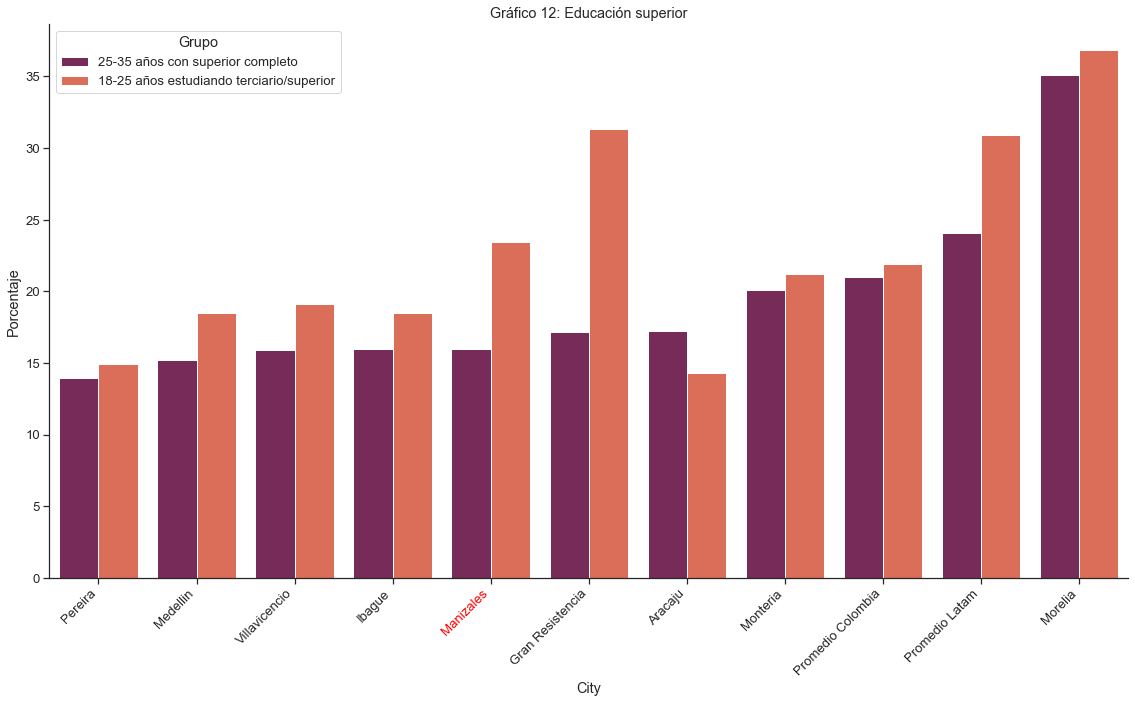

In [213]:
fig, ax = plt.subplots(figsize=(16,10))
g = sns.barplot(x=edu_plot2.index, y='Porcentaje', hue='Grupo', data=edu_plot2 , palette='rocket' , linewidth=1)

g.set_title('Gráfico 12: Educación superior')
g.set_xticklabels(edu_plot2.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.tight_layout()
plt.gca().get_xticklabels()[4].set_color('red')

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/edu2.png",bbox_inches='tight')

### Conglomerados y Cadenas de Valor

In [234]:
hh = laboral.loc['Colombia','Salario Horario (PPP 2011)'].to_frame().drop(index='Colombia 2018 (total ciudades)').join(sectores.loc[:,['Salario Estimado','HHc/HHp']])

In [235]:
hh = hh.reset_index()

In [239]:
hh = hh.rename(columns={'HHc/HHp':'Índice HH / Índice HH país','Salario Horario (PPP 2011)':'Salario Horario (USD)'})

In [236]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']))

'#831e5a'

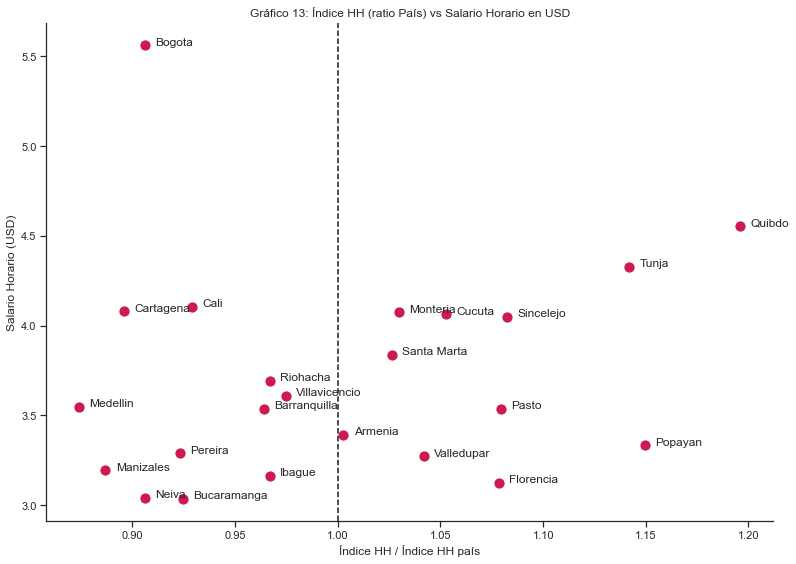

In [269]:
fig, ax = plt.subplots(figsize=(11,8))

sns.scatterplot(data=hh, x="Índice HH / Índice HH país", y="Salario Horario (USD)" , ax=ax  , s=125 , c=sns.color_palette('rocket',1)).set_title('Gráfico 13: Índice HH (ratio País) vs Salario Horario en USD') #, hue="Principal Sector (3 principales)",   size="Principal Sector (3 principales)" 

#plt.legend(bbox_to_anchor=(0.95,0.95), loc="upper right")
plt.tight_layout()
sns.set(font_scale=1.0)
sns.set_style("ticks")
sns.despine()
plt.axvline(x=1,linestyle='--',c=colors[1])

label_point( hh["Índice HH / Índice HH país"] , hh["Salario Horario (USD)"] , hh['City'] , ax)

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/hh_salario.png",bbox_inches='tight')

Distribución de masa salarial, empleo y salarios

In [272]:
e = sectores.iloc[:,10:20]

In [274]:
eplot = e.loc[idx[:,ref],:].droplevel(0)

In [276]:
eplot = eplot.rename(columns=dict(zip(eplot.columns.tolist(),[sectores.columns[31:41].tolist()[e] for e in range(10)])))

In [277]:
eplot['df']='Empleo'

In [279]:
ms = sectores.iloc[:,31:41]

In [280]:
msplot = ms.loc[idx[:,ref],:].droplevel(0)

In [281]:
msplot = msplot.rename(columns=dict(zip(msplot.columns.tolist(),[sectores.columns[31:41].tolist()[e] for e in range(10)])))

In [282]:
msplot['df']='Masa Salarial'

In [283]:
df = pd.concat([pd.melt(eplot.reset_index(),id_vars=['df','City']),pd.melt(msplot.reset_index(),id_vars=['df','City'])],ignore_index=True)

In [284]:
df = df.set_index(['df','City','variable'])

In [285]:
df["vcs"] = df.groupby(level=["df","City"]).cumsum()

In [286]:
df = df.reset_index()

Plotly

In [301]:
colors2 = [colors[e] for e in range(0,20,2)]

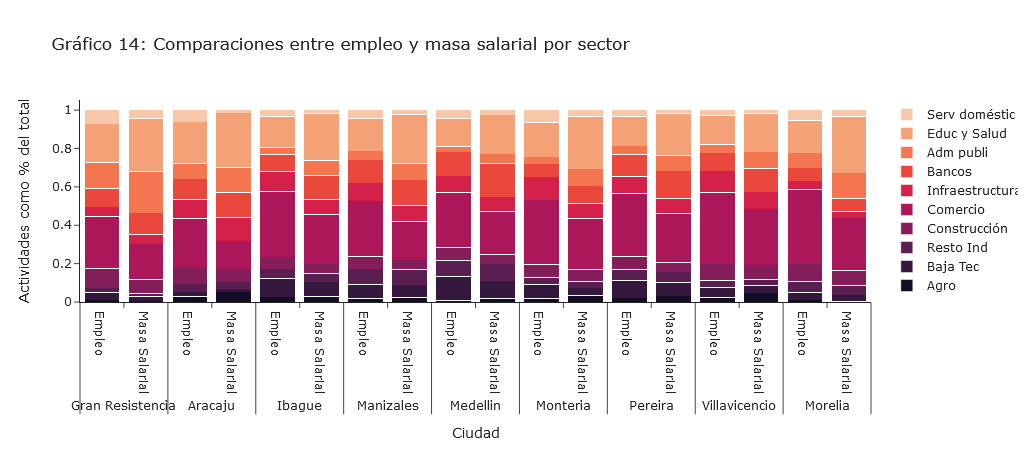

In [302]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Ciudad"),
    yaxis=dict(title_text="Actividades como % del total"),
    barmode="stack",
)


for r, c in zip(df.variable.unique(), colors2):
    plot_df = df[df.variable == r]
    fig.add_trace(
        go.Bar(x=[plot_df.City, plot_df.df], y=plot_df.value, name=r, marker_color=c),
    )

fig.update_layout(title_text='Gráfico 14: Comparaciones entre empleo y masa salarial por sector')
fig.write_html("informe/images/empleoymasasalarial.html",full_html=False,include_plotlyjs='cdn')
fig.show()

In [190]:
print(BeautifulSoup(a, 'html.parser').prettify())

<div>
 <script type="text/javascript">
  window.PlotlyConfig = {MathJaxConfig: 'local'};
 </script>
 <script src="https://cdn.plot.ly/plotly-latest.min.js">
 </script>
 <div class="plotly-graph-div" id="97af1ba3-41a1-4bca-9d8a-87363ff72d30" style="height:100%; width:100%;">
 </div>
 <script type="text/javascript">
  window.PLOTLYENV=window.PLOTLYENV || {};                                    if (document.getElementById("97af1ba3-41a1-4bca-9d8a-87363ff72d30")) {                    Plotly.newPlot(                        "97af1ba3-41a1-4bca-9d8a-87363ff72d30",                        [{"marker": {"color": "#221330"}, "name": "Agro", "type": "bar", "x": [["Armenia", "Bucaramanga", "Ibague", "Manizales", "Medellin", "Monteria", "Pereira", "Tunja", "Villavicencio", "Armenia", "Bucaramanga", "Ibague", "Manizales", "Medellin", "Monteria", "Pereira", "Tunja", "Villavicencio"], ["Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Masa Salarial", "Masa Salaria

Salarios

In [320]:
salarios = sectores.iloc[:,:10]

In [321]:
salariosm = salarios.mean().to_frame().T.append(salarios.loc['Colombia'].mean().to_frame().T)

In [322]:
salariosm['City'] = ['Promedio Colombia','Promedio Latam']

In [323]:
salariosm = salariosm.set_index(['City'])

In [324]:
salarios = salarios.droplevel(0).append(salariosm)

In [325]:
mydict=dict(zip(salarios.columns.tolist(),sectores.iloc[:5,31:41].columns.tolist()))

In [332]:
plot = salarios.loc[ref_prom].rename(columns=mydict).sort_values('Agro').stack().to_frame().reset_index().rename(columns={'level_1':'Actividad',0:'Salario'})

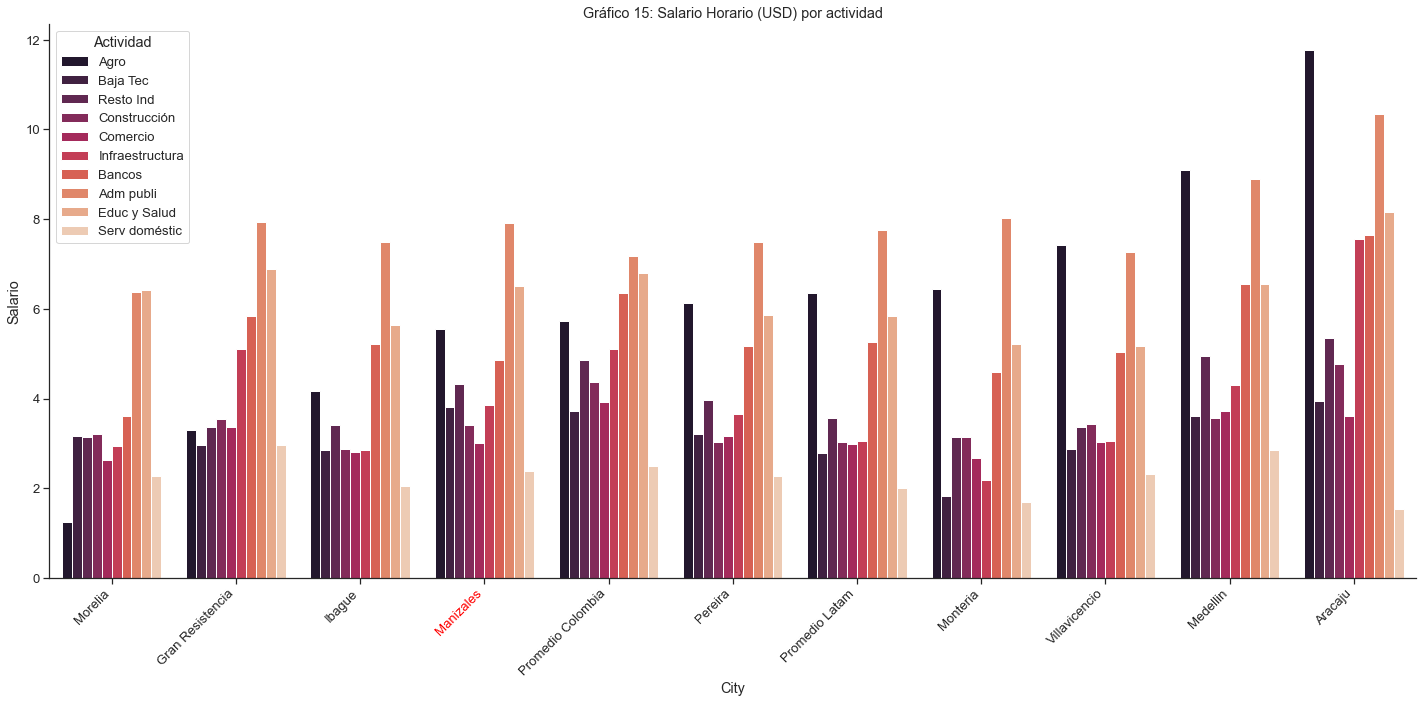

In [336]:
fig, ax = plt.subplots(1,1,figsize=(20,10)) #,constrained_layout=True

sns.barplot(x='City', y='Salario', hue='Actividad', data=plot , ax = ax, palette='rocket').set_title('Gráfico 15: Salario Horario (USD) por actividad')

#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xticklabels(plot['City'].unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.tight_layout()
plt.gca().get_xticklabels()[3].set_color('red')

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/salarios.png",bbox_inches='tight')

### Facilitación de Negocios

Doing BIZ Extra

In [842]:
db = pd.read_excel(direc+'dbizi.xlsx',index_col=[0,1])

In [847]:
db = db[db.columns[db.columns.str.contains('Días')].tolist()]

In [848]:
dbiz = pd.read_excel(direc+'dbiz_extras.xlsx')

In [849]:
dbiz = dbiz.dropna().set_index(['Country','City'])

In [850]:
db = db.append(dbiz).astype('float')

In [854]:
db = db.reset_index().drop_duplicates(subset=['Country','City']).set_index(['Country','City'])

Doing BIZ II

In [855]:
means = db.loc['Colombia'].mean().to_frame().T.append(db.loc['Mexico'].mean().to_frame().T).append(db.loc['Peru'].mean().to_frame().T)

In [857]:
means['City'] = ['Promedio Colombia','Promedio Mexico','Promedio Peru']

In [858]:
means = means.set_index('City')

In [859]:
ref_db = ref_prom[:-5] + ['Promedio Peru','Promedio Mexico','Varsovia','Madrid','Roma','Dublin','Atenas','Bucaramanga','Bogota']

In [863]:
db_plot = db.droplevel(0).append(means).loc[ref_db,:].iloc[:-1,:]

In [865]:
dp = pd.melt(db_plot.reset_index(),id_vars=['City'], value_vars=['Días permiso de construcción','Días registro de propiedad','Días comienzo de negocio'])

In [869]:
df1=dp[dp['variable']=='Días permiso de construcción'].sort_values('value').dropna()
df2=dp[dp['variable']=='Días registro de propiedad'].sort_values('value').dropna()
df3=dp[dp['variable']=='Días comienzo de negocio'].sort_values('value').dropna()

In [870]:
cl = [e for e in sns.color_palette('rocket',15)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2]

In [871]:
color2 = [colors[2]]*15
color4 = [colors[4]]*15
color6 = [colors[0]]*15

In [872]:
color2[2]=colors[8]
color4[1]=colors[8]
color6[1]=colors[8]

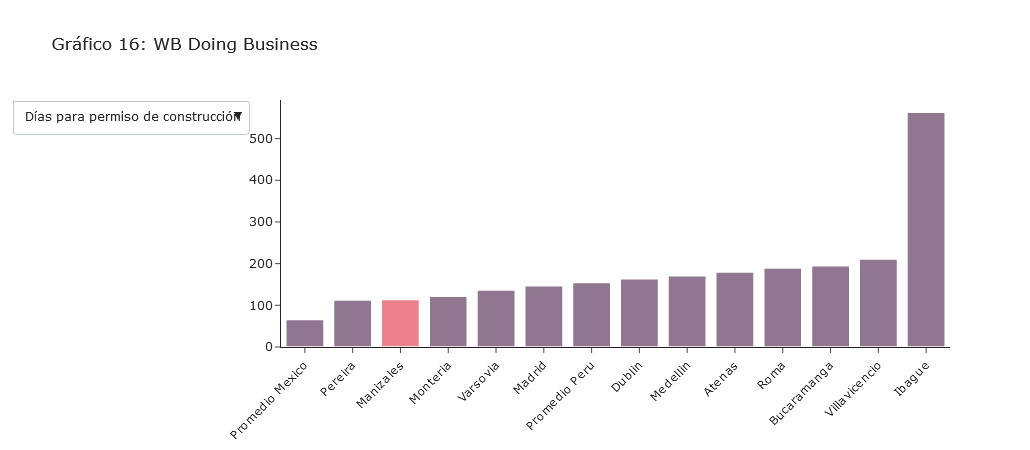

In [873]:
fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['value'] , marker={'color': color2})
                     ])

updatemenus = [
    {
        'buttons': [
            {
                'method': 'update',
                'label': 'Días para permiso de construcción',
                'args': [
                    {'y': [df1['value']],
                     'x': [df1['City']],
                     'marker':[{'color': color2}]
                    },  
                ]
            },
            {
                'method': 'update',
                'label': 'Días para registro de propiedad',
                'args': [
                    {'y': [df2['value']],
                     'x': [df2['City']],
                     'marker':[{'color': color4}]
                    },
                ]
            },
            {
                'method': 'update',
                'label': 'Días para comienzo de negocio',
                'args': [
                    {'y': [df3['value']],
                     'x': [df3['City']],
                     'marker':[{'color': color6}]
                    },
                ]
            }
        ],
        'direction': 'down',
        'showactive': True,
    }
]

fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico 16: WB Doing Business' , xaxis={'tickangle':-45})
fig.update_traces(marker_line_width=1.5, opacity=0.6)

fig.show()
fig.write_html("informe/images/db.html",full_html=False,include_plotlyjs='cdn')

Homicidios

In [514]:
homicidios = pd.read_excel(direc+'homicidios.xlsx',index_col=[0])

In [516]:
med = homicidios.mean().to_frame().T

In [517]:
med['City'] = 'Promedio Colombia'

In [518]:
med = med.set_index('City')

In [519]:
homicidios = homicidios.append(med)

In [524]:
ref_com = ['Manizales',
 'Pereira',
 'Medellin',
 'Armenia',
 'Villavicencio',
 'Monteria',
 'Bucaramanga',
 'Ibague',
 'Bogota',
 'Tunja',
 'Promedio Colombia',
 'Cali']

In [526]:
homicidios_ref = homicidios.loc[ref_com,'Tasa (100.000 habitantes)'].to_frame().sort_values('Tasa (100.000 habitantes)')

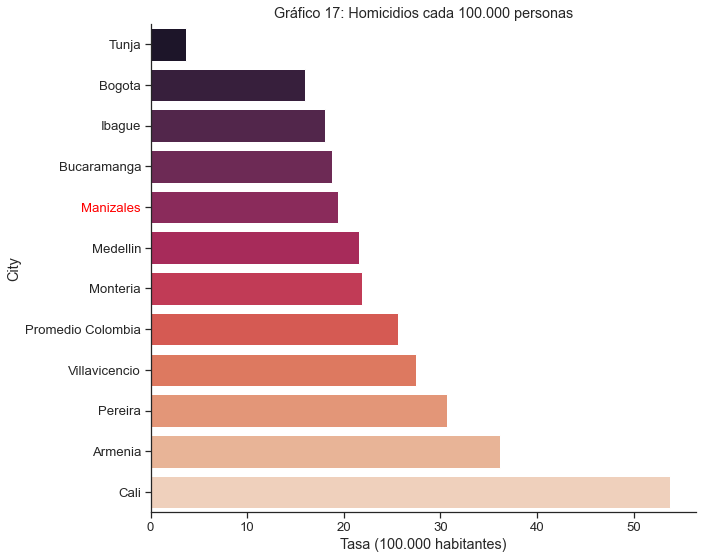

In [529]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Tasa (100.000 habitantes)', y=homicidios_ref.index, data=homicidios_ref , palette='rocket' , orient='h' ).set_title('Gráfico 17: Homicidios cada 100.000 personas')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.tight_layout()
plt.gca().get_yticklabels()[4].set_color('red')

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/homicidios.png",bbox_inches='tight')

Properati

Porcentajes de propiedas según moneda de publicación

In [532]:
prope = pd.read_excel(direc+'properati_i.xlsx',index_col=[0,1])

In [533]:
mylist = []

for file in os.listdir(r'C:\Users\Franco\Python\CAF\files\properati'):
    if file.endswith(".csv"):
        mylist += [file]

In [534]:
prope = pd.DataFrame()

for file in mylist:
    df = pd.read_csv(r'C:\Users\Franco\Python\CAF\files\properati\{}'.format(file))
    prope = prope.append(df)

In [535]:
prope = prope.drop(columns=['ad_type','rooms','bedrooms','bathrooms','title','description'])

In [633]:
prope = prope.loc[prope['operation_type']=='Venta',:]

In [555]:
#Diagnóstico

In [634]:
freq = prope[(~prope['l1'].isin(['Brasil','Estados Unidos','Estados Unidos de América']))].groupby(['l1','currency']).count()['price'].to_frame()

In [635]:
tot = prope[~prope['l1'].isin(['Brasil','Estados Unidos','Estados Unidos de América'])].groupby(['l1']).count()['price'].to_frame().rename(columns={'price':'Total'})

In [636]:
porcen = freq.join(tot)

In [637]:
porcen = porcen.reset_index().rename(columns={'l1':'Country','currency':'Moneda','price':'Avisos'}).set_index('Country')

In [638]:
porcen = porcen.sort_values(['Country','Moneda'])

In [639]:
porcen['Proporción'] = porcen['Avisos'] / porcen['Total']

In [640]:
porcen = porcen.drop(columns=['Avisos','Total']).pivot(columns='Moneda')

In [641]:
porcen = porcen.droplevel(0,axis=1)

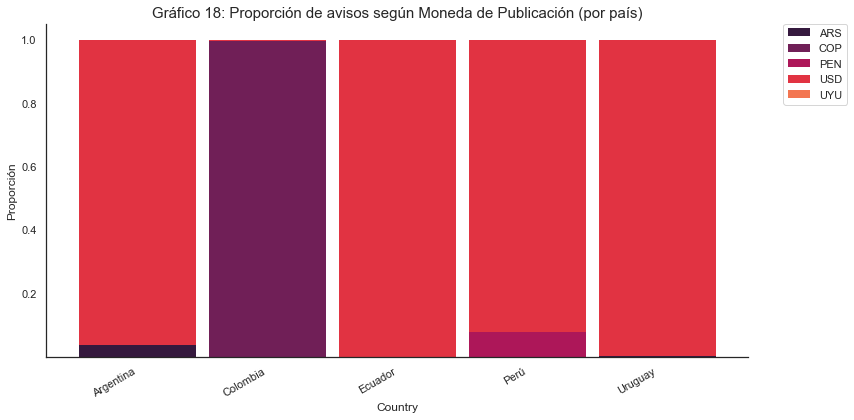

In [761]:
sns.set_palette('rocket')
sns.set_style('white')

fig, ax = plt.subplots(1, 1,figsize=(12,6))

porcen.plot(kind='bar', stacked=True , ax=ax , color=sns.color_palette() , width=0.9 , linewidth=0.001).set_title('Gráfico 18: Proporción de avisos según Moneda de Publicación (por país)',fontsize=15)

fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.set(font_scale = 1)
ax.set_ylabel('Proporción')

plt.tight_layout()
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 3/informe/images/prope_2.png",bbox_inches='tight')

Cantidad de sueldos mensuales para una vivienda

Gráfico

In [715]:
prop_comercial = pd.read_excel(direc+'properati.xlsx',index_col=[0,1])

In [726]:
media = prop_comercial.loc['Colombia',['Property Type', 'price m2']]

In [727]:
media = media.groupby('Property Type').mean()

In [728]:
media['City'] = 'Promedio Colombia'

In [729]:
media = media.reset_index().set_index(['City','Property Type'])

df

In [730]:
ref_p = ['Armenia','Manizales','Medellin','Monteria','Bucaramanga','Cartagena','Bahia Blanca','Mendoza','Lima','Guayaquil','Bogota D.C','Ibague','Quito','Rosario','Barranquila','Cali','Montevideo','Buenos Aires']

In [731]:
pplot = prop_comercial.loc[idx[:,ref_p],:]

In [733]:
pplot = pplot.drop(columns=['price','surface'])

In [742]:
df = pplot.droplevel(0).append(media).reset_index()

In [743]:
df = df.rename(columns={'index':'City'})

In [745]:
df1=df[df['Property Type']=='Depósito'].sort_values('price m2').dropna()
df2=df[df['Property Type']=='Local comercial'].sort_values('price m2').dropna()
df3=df[df['Property Type']=='Oficina'].sort_values('price m2').dropna()

In [746]:
for e in [df1,df2,df3]:
    print(e.index[e['City']=='Manizales'])

Int64Index([], dtype='int64')
Int64Index([27], dtype='int64')
Int64Index([28], dtype='int64')


In [747]:
for e in [df1,df2,df3]:
    print(len(e))

12
16
16


In [754]:
cl = [e for e in sns.color_palette('rocket',20)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2]

In [755]:
color2 = [colors[2]]*12
color4 = [colors[4]]*16
color6 = [colors[0]]*16

In [756]:
#color2[2]=colors[8]
color4[3]=colors[8]
color6[2]=colors[8]

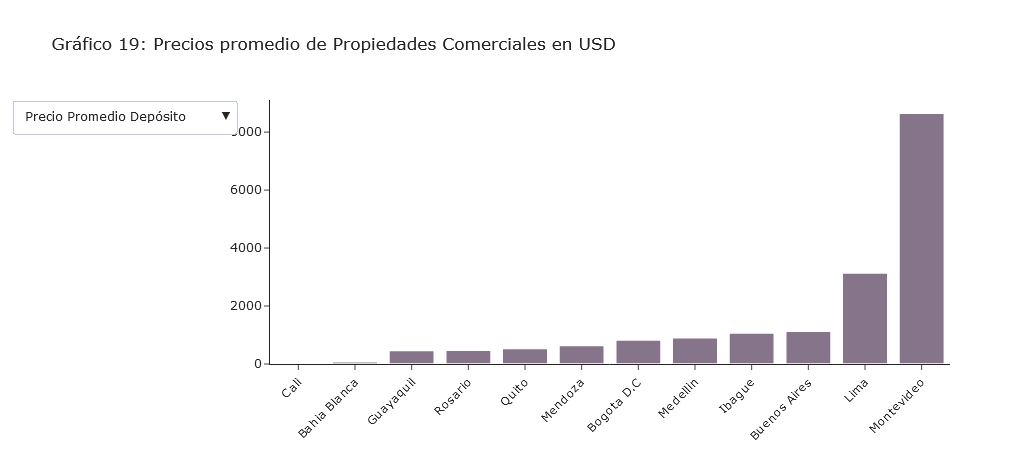

In [757]:
fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['price m2'] , marker={'color': color2})
                     ])

updatemenus = [
    {
        'buttons': [
            {
                'method': 'update',
                'label': 'Precio Promedio Depósito',
                'args': [
                    {'y': [df1['price m2']],
                     'x': [df1['City']],
                     'marker':[{'color': color2}]
                    },  
                ]
            },
            {
                'method': 'update',
                'label': 'Precio Promedio Local comercial',
                'args': [
                    {'y': [df2['price m2']],
                     'x': [df2['City']],
                     'marker':[{'color': color4}]
                    },
                ]
            },
            {
                'method': 'update',
                'label': 'Precio Promedio Oficina',
                'args': [
                    {'y': [df3['price m2']],
                     'x': [df3['City']],
                     'marker':[{'color': color6}]
                    },
                ]
            }
        ],
        'direction': 'down',
        'showactive': True,
    }
]

fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico 19: Precios promedio de Propiedades Comerciales en USD' , xaxis={'tickangle':-45})
fig.update_traces(marker_line_width=1.5, opacity=0.6)

fig.show()
fig.write_html("informe/images/prope.html",full_html=False,include_plotlyjs='cdn')